In [1]:
# Install transformers from the GitHub repository
!pip install git+https://github.com/huggingface/transformers.git

# Install other required packages
!pip install accelerate
!pip install datasets
!pip install peft
!pip install bitsandbytes

  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-tj_fe_c5
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-tj_fe_c5
  Resolved https://github.com/huggingface/transformers.git to commit 25245ec26dc29bcf6102e1b4ddd0dfd02e720cf5
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.42.0.dev0-py3-none-any.whl size=9140092 sha256=193b75738b072fe19484b2997da241a7fb77e521b1f595a65fd9fbe02c90ee86
  Stored in directory: /tmp/pip-ephem-wheel-cache-xhh4sjy6/wheels/e7/9c/5b/e1a9c8007c343041e61cc484433d512ea9274272e3fcbe7c16
Successfully built transformers
  Attempting uninstall: transformers
    Found existing installation: transformers 4.41.1
    Uninstalling transformers-4.41.1:
      Successfully uninstalled transformers-4.41.1
ERROR: Could not install pac

**Load Dataset**

In [2]:
import json

with open('/kaggle/input/mlr-captioning-challenge-data/MLR Captioning Challenge Data/memes-trainval.json', 'r') as f:
    dataset = json.load(f)

dataset[0]

{'category': 'memes',
 'img_captions': ['Person in Spider Man outfit gives a lecture on stage.',
  'Person dressed as spider man stands in front of crowd with notes'],
 'meme_captions': ['Meme poster is frustrated about the format of the website and is making a suggestion for improvement.'],
 'title': 'For real though',
 'url': 'https://i.redd.it/m16dhaqyply21.jpg',
 'img_fname': 'memes_bpet7l.png',
 'metaphors': [{'metaphor': 'Spider Man outfit', 'meaning': 'Meme poster'},
  {'metaphor': 'a lecture', 'meaning': 'complaint'},
  {'metaphor': 'spider man', 'meaning': 'Meme poster'},
  {'metaphor': 'crowd', 'meaning': 'meme readers'}],
 'post_id': 'bpet7l'}

In [3]:
import os
from PIL import Image

for data in dataset[:100]:
    image_filename = data['img_fname']
    image_path = os.path.join('/kaggle/input/mlr-captioning-challenge-data/MLR Captioning Challenge Data/memes/', image_filename)
    image = Image.open(image_path)
    image = image.resize((224, 224))
    image = image.convert('L')
    data['image'] = image
    data['img_captions'] = "".join(data['img_captions'])
    data['meme_captions'] = data['meme_captions'][0]
    
dataset[0]

{'category': 'memes',
 'img_captions': 'Person in Spider Man outfit gives a lecture on stage.Person dressed as spider man stands in front of crowd with notes',
 'meme_captions': 'Meme poster is frustrated about the format of the website and is making a suggestion for improvement.',
 'title': 'For real though',
 'url': 'https://i.redd.it/m16dhaqyply21.jpg',
 'img_fname': 'memes_bpet7l.png',
 'metaphors': [{'metaphor': 'Spider Man outfit', 'meaning': 'Meme poster'},
  {'metaphor': 'a lecture', 'meaning': 'complaint'},
  {'metaphor': 'spider man', 'meaning': 'Meme poster'},
  {'metaphor': 'crowd', 'meaning': 'meme readers'}],
 'post_id': 'bpet7l',
 'image': <PIL.Image.Image image mode=L size=224x224>}

In [4]:
import torch
from torch.utils.data import random_split

In [5]:
train_dataset, eval_dataset = random_split(dataset, [5000, 823])

In [6]:
train_dataset[0]

{'category': 'memes',
 'img_captions': 'A man looks nervous in his room.',
 'meme_captions': 'Meme poster is trying to convey that their $40 watch does the same thing as a $100,000 watch.',
 'title': 'Celebrities foool',
 'url': 'https://i.redd.it/hc30d9qpzay61.jpg',
 'img_fname': 'memes_n9606v.png',
 'metaphors': [{'metaphor': 'A man', 'meaning': 'Meme poster'},
  {'metaphor': 'his room', 'meaning': 'not related to the meme context'},
  {'metaphor': 'looks', 'meaning': 'not related to the meme context'}],
 'post_id': 'n9606v',
 'image': <PIL.Image.Image image mode=L size=224x224>}

**Import Model**

In [32]:
import torch
from peft import LoraConfig
from transformers import AutoProcessor, BitsAndBytesConfig, Idefics2ForConditionalGeneration

DEVICE = "cuda:0"
USE_LORA = False
USE_QLORA = True

processor = AutoProcessor.from_pretrained(
    "HuggingFaceM4/idefics2-8b",
    do_image_splitting=False
)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


**Configure LoRA adapters**

In [9]:
Idefics2ForConditionalGeneration

transformers.models.idefics2.modeling_idefics2.Idefics2ForConditionalGeneration

In [5]:
if USE_QLORA or USE_LORA:
    lora_config = LoraConfig(
        r=8,
        lora_alpha=8,
        lora_dropout=0.1,
        target_modules='.*(text_model|modality_projection|perceiver_resampler).*(down_proj|gate_proj|up_proj|k_proj|q_proj|v_proj|o_proj).*$',
        use_dora=False if USE_QLORA else True,
        init_lora_weights="gaussian"
    )
    if USE_QLORA:
        bnb_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.float16
        )
    model = Idefics2ForConditionalGeneration.from_pretrained(
        "HuggingFaceM4/idefics2-8b",
        torch_dtype=torch.float16,
        quantization_config=bnb_config if USE_QLORA else None,
    )
    model.add_adapter(lora_config)
    model.enable_adapters()
else:
    model = Idefics2ForConditionalGeneration.from_pretrained(
        "HuggingFaceM4/idefics2-8b",
        torch_dtype=torch.float16,
        _attn_implementation="flash_attention_2", # Need GPUs like A100 or H100.
    ).to(DEVICE)

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now set to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/74.4k [00:00<?, ?B/s]

model-00001-of-00007.safetensors:   0%|          | 0.00/4.64G [00:00<?, ?B/s]

model-00002-of-00007.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00003-of-00007.safetensors:   0%|          | 0.00/4.90G [00:00<?, ?B/s]

model-00004-of-00007.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00005-of-00007.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00006-of-00007.safetensors:   0%|          | 0.00/4.83G [00:00<?, ?B/s]

model-00007-of-00007.safetensors:   0%|          | 0.00/4.25G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

In [ ]:
print(model)

**Create Data Collator**

In [33]:
import random

class MyDataCollator:
    def __init__(self, processor):
        self.processor = processor
        self.image_token_id = processor.tokenizer.additional_special_tokens_ids[
            processor.tokenizer.additional_special_tokens.index("<image>")
        ]

    def __call__(self, examples):
        texts = []
        images = []
        for example in examples:

            image = example['image']
            img_captions = example["img_captions"]
            meme_captions = example["meme_captions"]
            messages = [
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": "Answer briefly."},
                        {"type": "image"},
                        {"type": "text", "text": img_captions}
                    ]
                },
                {
                    "role": "assistant",
                    "content": [
                        {"type": "text", "text": random.choice(meme_captions)}
                    ]
                }
            ]
            text = processor.apply_chat_template(messages, add_generation_prompt=False)
            texts.append(text.strip())
            images.append([image])

        batch = processor(text=texts, images=images, return_tensors="pt", padding=True)

        labels = batch["input_ids"].clone()
        labels[labels == processor.tokenizer.pad_token_id] = self.image_token_id
        batch["labels"] = labels
        

        return batch

data_collator = MyDataCollator(processor)

**Setup training parameters**

In [7]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir = "/kaggle/working/",
    learning_rate = 2e-4,
    fp16 = True,
    per_device_train_batch_size = 1,
    gradient_accumulation_steps = 8,
    dataloader_pin_memory = False,
    save_total_limit = 3,
    save_strategy = "steps",
    save_steps = 100,
    max_steps = 100,
    logging_steps = 5,
    remove_unused_columns = False,
    push_to_hub=False,
    label_names = ["labels"],
    load_best_model_at_end = False,
    report_to = "none",
    optim = "paged_adamw_8bit",
)

In [8]:
trainer = Trainer(
    model = model,
    args = training_args,
    data_collator = data_collator,
    train_dataset = dataset[:100]
)

max_steps is given, it will override any value given in num_train_epochs


**Start Training**

In [9]:
trainer.train()

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss
5,18723.676600
10,0.000000
15,0.000000
20,0.000000
25,0.000000
30,0.000000
35,0.000000
40,0.000000
45,0.000000
50,0.000000


/opt/conda/lib/python3.10/site-packages/transformers/integrations/peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


TrainOutput(global_step=100, training_loss=936.183828125, metrics={'train_runtime': 1816.4097, 'train_samples_per_second': 0.881, 'train_steps_per_second': 0.055, 'total_flos': 8516726467626432.0, 'train_loss': 936.183828125, 'epoch': 16.0})

**Save Model**

In [10]:
model.save_pretrained('/kaggle/working/fine-tuned-model')

/opt/conda/lib/python3.10/site-packages/transformers/integrations/peft.py:399: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


**Evaluate the model**

In [19]:
print(model)

Idefics2ForConditionalGeneration(
  (model): Idefics2Model(
    (vision_model): Idefics2VisionTransformer(
      (embeddings): Idefics2VisionEmbeddings(
        (patch_embedding): Conv2d(3, 1152, kernel_size=(14, 14), stride=(14, 14), padding=valid)
        (position_embedding): Embedding(4900, 1152)
      )
      (encoder): Idefics2Encoder(
        (layers): ModuleList(
          (0-26): 27 x Idefics2EncoderLayer(
            (self_attn): Idefics2VisionAttention(
              (k_proj): Linear4bit(in_features=1152, out_features=1152, bias=True)
              (v_proj): Linear4bit(in_features=1152, out_features=1152, bias=True)
              (q_proj): Linear4bit(in_features=1152, out_features=1152, bias=True)
              (out_proj): Linear4bit(in_features=1152, out_features=1152, bias=True)
            )
            (layer_norm1): LayerNorm((1152,), eps=1e-06, elementwise_affine=True)
            (mlp): Idefics2VisionMLP(
              (activation_fn): PytorchGELUTanh()
              

In [11]:
test_example = dataset[0]
test_example

{'category': 'memes',
 'img_captions': 'Person in Spider Man outfit gives a lecture on stage.Person dressed as spider man stands in front of crowd with notes',
 'meme_captions': 'Meme poster is frustrated about the format of the website and is making a suggestion for improvement.',
 'title': 'For real though',
 'url': 'https://i.redd.it/m16dhaqyply21.jpg',
 'img_fname': 'memes_bpet7l.png',
 'metaphors': [{'metaphor': 'Spider Man outfit', 'meaning': 'Meme poster'},
  {'metaphor': 'a lecture', 'meaning': 'complaint'},
  {'metaphor': 'spider man', 'meaning': 'Meme poster'},
  {'metaphor': 'crowd', 'meaning': 'meme readers'}],
 'post_id': 'bpet7l',
 'image': <PIL.Image.Image image mode=L size=224x224>}

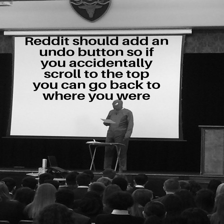

In [12]:
test_example["image"]

In [16]:
import shutil
import os

# Define the directory you want to compress
dir_to_compress = '/kaggle/working/fine-tuned-model'
# Define the output ZIP file path
zip_file_path = '/kaggle/working/fine-tuned-model.zip'

# Compress the directory
shutil.make_archive(zip_file_path.replace('.zip', ''), 'zip', dir_to_compress)

# Verify the ZIP file is created
print(f"Created {zip_file_path}")

Created /kaggle/working/fine-tuned-model.zip


In [25]:
import shutil
import os

# Define the directory you want to compress
dir_to_compress = '/kaggle/working/checkpoint-100'
# Define the output ZIP file path
zip_file_path = '/kaggle/working/checkpoint-100.zip'

# Compress the directory
shutil.make_archive(zip_file_path.replace('.zip', ''), 'zip', dir_to_compress)

# Verify the ZIP file is created
print(f"Created {zip_file_path}")

Created /kaggle/working/checkpoint-100.zip
